# Gravity model

In [1]:
import numpy as np
import pandas as pd
#import matplotlib
import matplotlib.pyplot as plt
from pandas.stats.api import ols
%pylab inline
RootPath = '/Users/CQ/Documents/Project1'

Populating the interactive namespace from numpy and matplotlib


In [142]:
import matplotlib.patches as mpatches

In [3]:
from descartes import PolygonPatch
from shapely.geometry.polygon import Polygon

In [2]:
from GravModel import GravModel as GM

Failed `CDLL(/Library/Frameworks/GEOS.framework/Versions/Current/GEOS)`


### Notes for following function:
* The input argument **level** is for the number of groups, i.e. different colors.
* For each zip code, its correspondent value is now **$ln(W^{out}_{zip}) - ln(area_{zip})$** instead of the simple **$ln(W^{out}_{zip})$**, so we can have a clearer look at the density instead of cumulative effect (although subtracting ln(area) would yield all negative results)
* The brighter color indicates the areas with higher values with their **$ln(W^{out}_{zip}) - ln(area_{zip})$**, namely higher mobility density. So the 10% in our legend means the "bottom 10%"

In [237]:
def PlotMap(df, fig, zips = GM.geo_NY, key = 'part', layout = 111, loc_ix = 0, alpha = 0.7,
            mode = 1, density = 0, cmap_name = 'spectral', title = 'Community Map'):
    '''
    The function is for map plotting
    The arguments are:
    df       --- data frame
    fig      --- controls the figure to plot on
    key      --- the column name that user defined for determine color
    (default setting is 'part' for mode 1, partition)
    (may be 'weight' for mode 2, heatmap)
    layout   --- determines the subplot layout, default at 111
    loc_ix   --- the plot locatin index
    mode     --- 1 is for integer partitions, groups or clusters
             --- 2 is for non-integer partition, such as heatmap
    levels   --- the number of clusters if mode == 1
             --- else set it equal to 100 for heatmap (mode 2)
    
    '''
    zips.postalCode = zips.postalCode.astype(int)
    ax = fig.add_subplot(layout + loc_ix)
    # if we are plotting partition
    if mode == 1:
        levels = 10
        p = zips.merge(df, on='postalCode', how='inner')
        m = len(p)
        p['Rank'] = p[key].rank(method = 'min') * levels/m - 1.0/m
        p.Rank = p.Rank.astype(int)
        p['part'] = p[key] - np.log(p.Shape_Area) if density else p[key]
    # if we are plotting heatmap
    else:
        levels = 100
    color_func = matplotlib.cm.get_cmap(cmap_name)
    color = list(color_func(np.linspace(0,1,levels-1)))
    color.append([0.,0.,0.,1.])
    
    
    percent = [i*100.0/levels for i in xrange(levels)]
    percent_label = ["{:2.0f}".format(percent[i])+'% ~ '+"{:2.0f}".format(percent[i+1])+'%' for i in xrange(levels - 1)]
    percent_label.append('> '+"{:2.0f}".format(percent[-1])+'%')
    interval = [np.percentile(p.part, i) for i in percent]
    interval_label = ["({:2.2f}".format(interval[i])+' ~ '+"{:2.2f}".format(interval[i+1])+')' for i in xrange(levels - 1)]
    interval_label.append('(> '+"{:2.2f}".format(interval[-1])+')')
    label = [percent_label[i]+' '+interval_label[i] for i in xrange(levels)]
    #part = [label[i] for i in p.Rank]

    #color = [[0.3+0.7*i,0.9*i,1] for i in np.linspace(1,0,levels-1)]
    #color.append([0.1,0,1])
    for s in xrange(m):
        poly = Polygon(p.geometry[s])
        c = color[p.Rank[s]][0:3]
        ax.add_patch(PolygonPatch(poly, fc = c, ec = 'k', alpha = alpha, zorder = 2))
    
    handles = [mpatches.Patch( color = color[i][0:3], label=label[i]) for i in xrange(levels)]
    plt.legend(handles = handles)
    plt.title(title, fontweight = 'bold', size = 18)
    ax.axis('scaled')

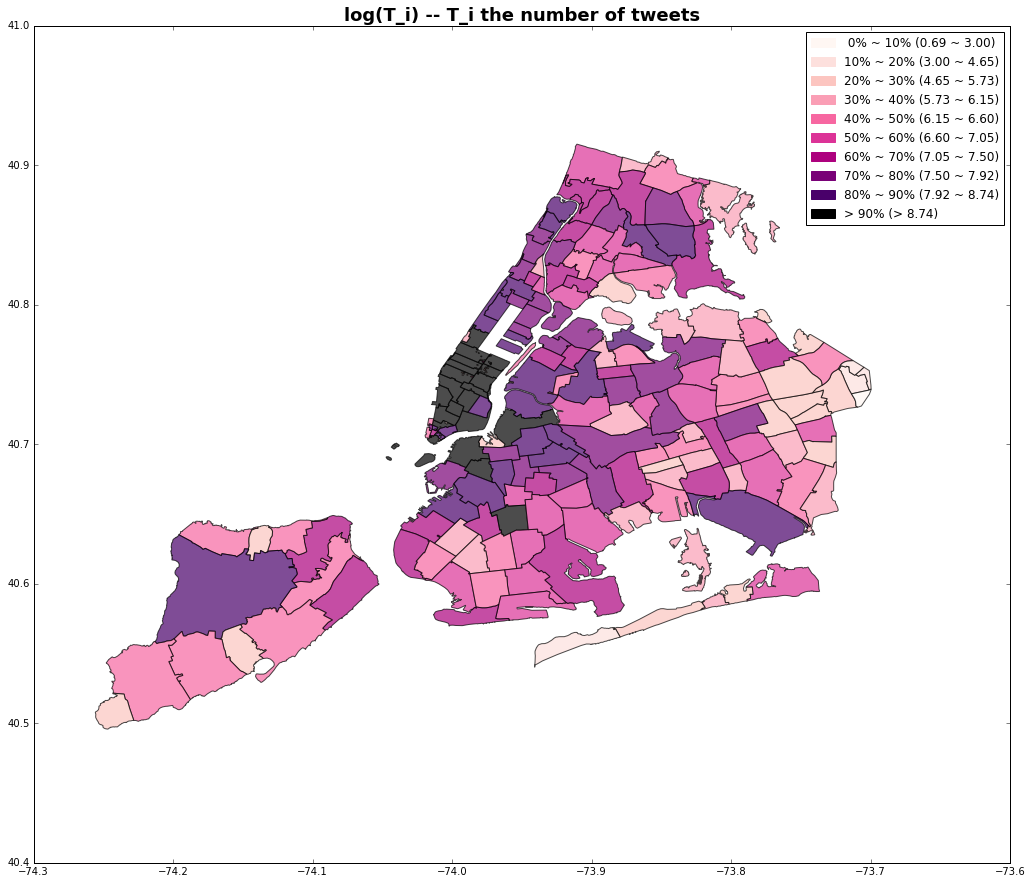

In [240]:
fig2 = plt.figure(figsize=(18,15))
PlotMap(GM.DF_Wout2, fig2, key = 'log_cent', cmap_name='RdPu', title = 'log(T_i) -- T_i the number of tweets')

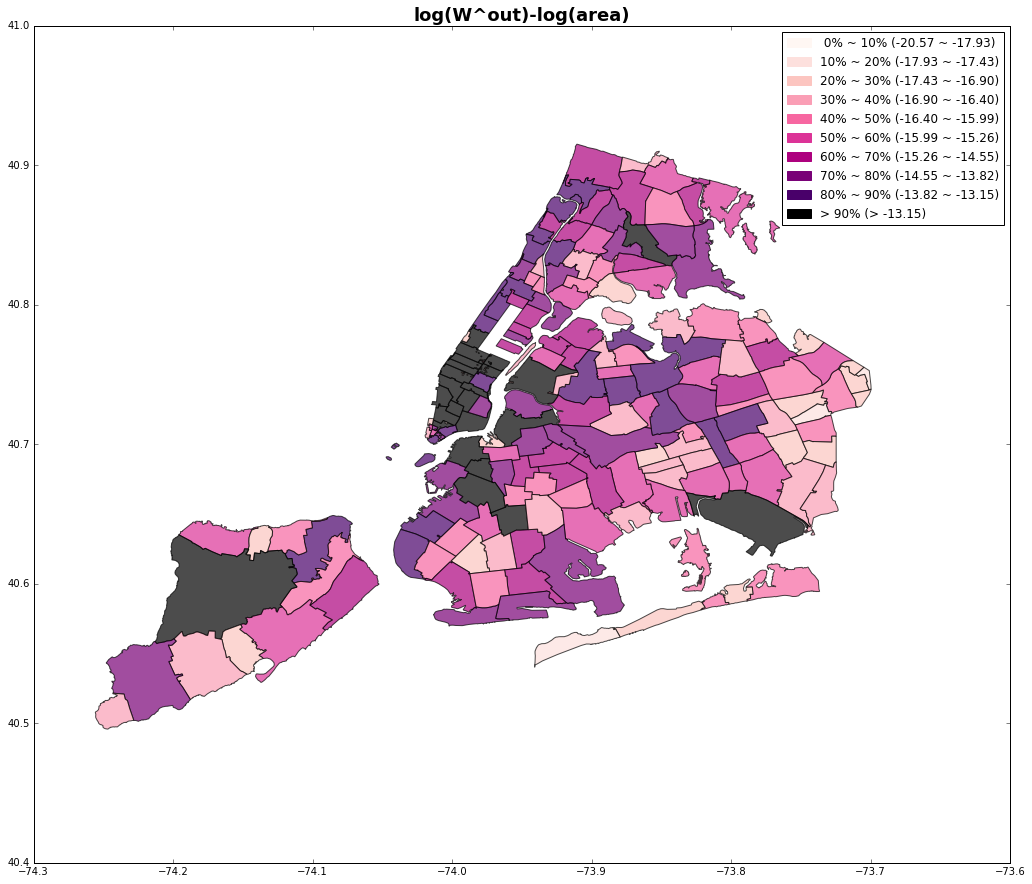

In [241]:
fig1 = plt.figure(figsize=(18,15))
PlotMap(GM.DF_Wout2, fig1, key = 'weight', cmap_name='RdPu', title = 'log(W^out)-log(area)', density=1)

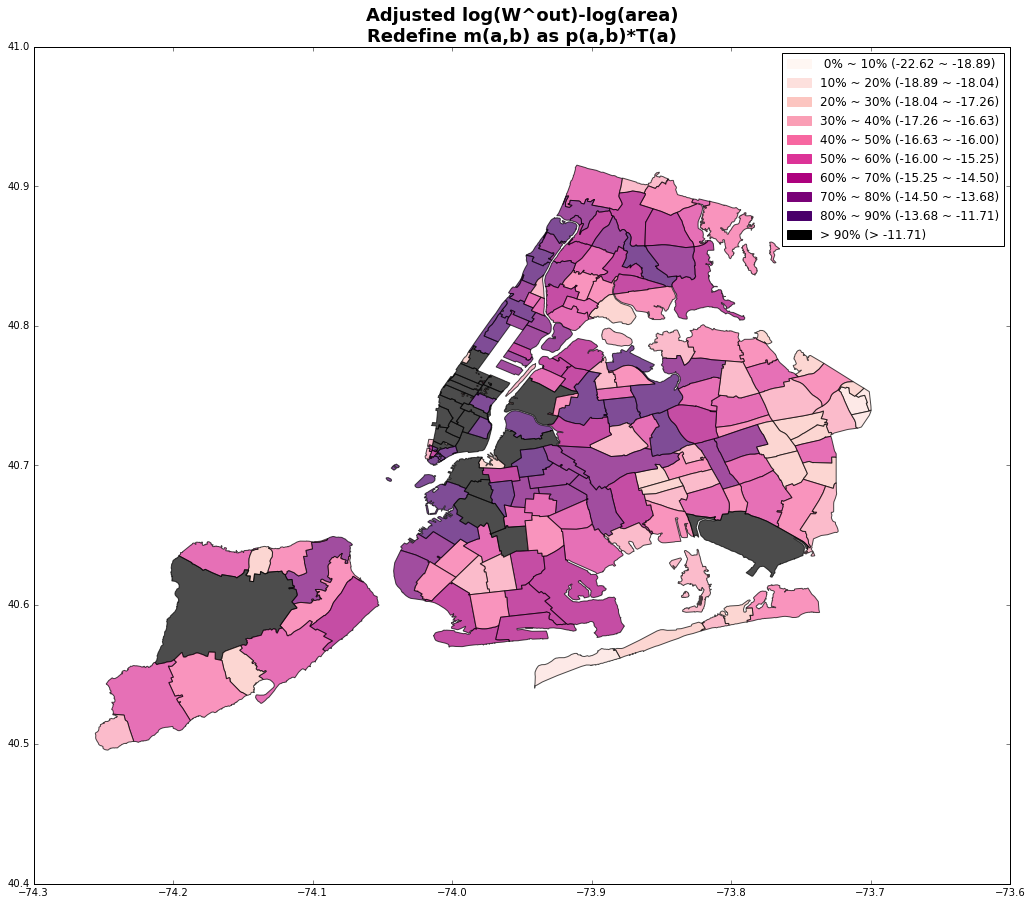

In [243]:
fig3 = plt.figure(figsize=(18,15))
PlotMap(GM.DF_Wout2_adj, fig3, key = 'weight', cmap_name='RdPu',
        title = 'Adjusted log(W^out)-log(area)\nRedefine m(a,b) as p(a,b)*T(a)', density=1)

In [34]:
a = GM.DF_Wout2[(10301 <= GM.DF_Wout2.postalCode)& (GM.DF_Wout2.postalCode <= 10314)]
a

,postalCode,weight,log_cent
98,10301,1.571501,7.415777
99,10302,-0.874747,4.969813
100,10303,0.799759,6.366470
101,10304,0.092442,6.284134
102,10305,1.029622,7.067320
103,10306,0.744422,6.432940
104,10307,-0.154030,5.332719
105,10308,-0.689961,5.455321
106,10309,1.401629,6.406880
107,10310,-0.062192,6.591674


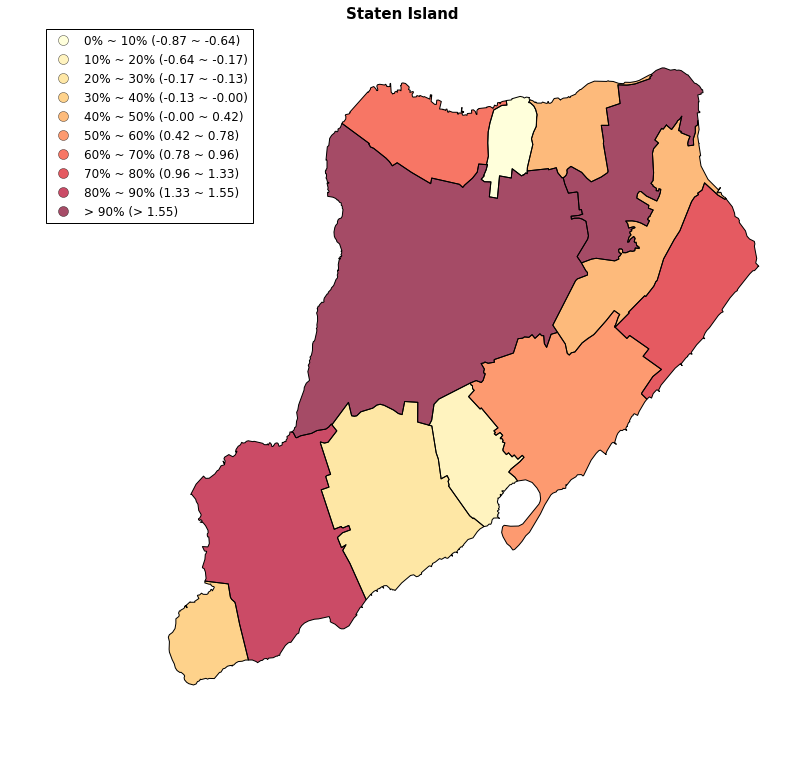

In [55]:
fig3 = plt.figure(figsize=(13,13))
GM.PlotMapPart(fig3, a.iloc[:,[0,1]], title = 'Staten Island', size = 111,levels = 10, cmap = 'YlOrRd')

## So zip code 10314 is the Mid-Island, which has the largest area in Staten Island. Even before we adjusting the network $m(a,b) = T(a) \cdot p(a,b)$, 11304 is already the top weight zip code there. CUNY college of Staten Island is located here so I guess this contributes a lot to why this zip code has highest amount of activities.

# Next adjust weight by adding T(a):  $m(a,b) = T(a) \cdot p(a,b)$

## First take a look at the $log(W^{out}_i)$ and $log(W^{in}_i)$, see if they only differ from an amount of $log(T(a))$

In [5]:
diff = GM.DF_Win2_adj.weight + GM.DF_Wout2_adj.log_cent - GM.DF_Wout2_adj.weight

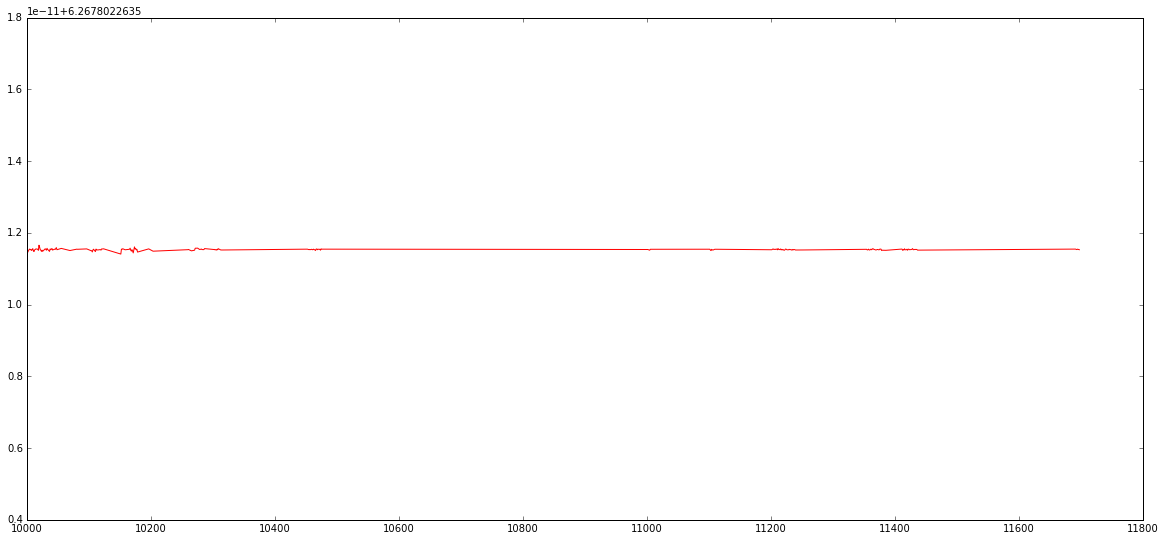

In [11]:
plt.plot(GM.PLACES, diff,'-r')

## So after our adjustment $m(a,b) = T(a) \cdot p(a,b)$, the difference between $log(W^{out}_i)$ vs $log(W^{in}_i) + log(T_i)$ is indeed a constant, but not zero.
### According to the computation, $$log(W^{out}_i) - (log(W^{in}_i) + log(T_i)) = 6.267802$$ Consider $log(6.267802) \approx 1.8354$ and $exp(6.267802)\approx 527.317 $, none of them makes sense to me where this number comes from.

## We take a glance at the relationship of $ln(W^{out}_i)$ vs $ln(T_i)$
## where $T_i$ denotes the number of tweets posted within zip code $i$

The coefficients of this model are: c = 0.906160, d = -5.741231
The R square of this model is 0.923247


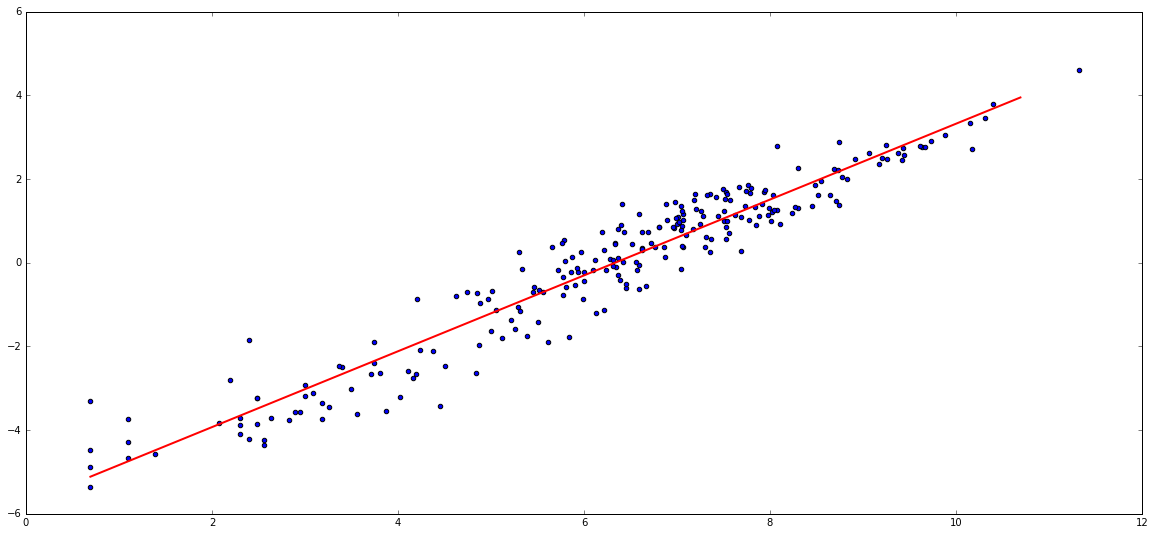

In [6]:
X = GM.DF_Wout2.log_cent
Y = GM.DF_Wout2.weight
WOvsT = ols(x=X,y=Y)
(c,d) = WOvsT.beta
plt.scatter(X, Y)
plt.plot(np.arange(min(X), max(X)), [c*i+d for i in np.arange(min(X), max(X))], '-r', lw=2)
print('The coefficients of this model are: c = %f, d = %f'%(c,d))
print('The R square of this model is %f'%WOvsT.r2)

In [43]:
WOvsT


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <x> + <intercept>

Number of Observations:         238
Number of Degrees of Freedom:   2

R-squared:         0.9232
Adj R-squared:     0.9229

Rmse:              0.5606

F-stat (1, 236):  2838.8065, p-value:     0.0000

Degrees of Freedom: model 1, resid 236

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
             x     0.9062     0.0170      53.28     0.0000     0.8728     0.9395
     intercept    -5.7412     0.1126     -50.98     0.0000    -5.9620    -5.5205
---------------------------------End of Summary---------------------------------

### So the values of $ln(W^{out}_i)$ are indeed showing strong linear correlation with $ln(T_i)$, which inspires us to predict $ln(W^{out}_i)$ as long as $T_i$ are available.
### And the model looks like this $$ln(W^{out}_i) \approx 0.906160 \cdot ln(T_i) - 5.741231$$ or equivalently, $$W^{out}_i \approx  0.00321 \cdot T^{0.90616}_i$$

# And it's worth noticing that the relationship between $W^{out}_i$ and $T_i$ is underlinear, 1 is not even in our 95% confidence interval.

## Next we present the $ln(f(distance))$ with respect to the average distance within each bin, where the bins are determined by the percentile of distribution of all distance data in NYC

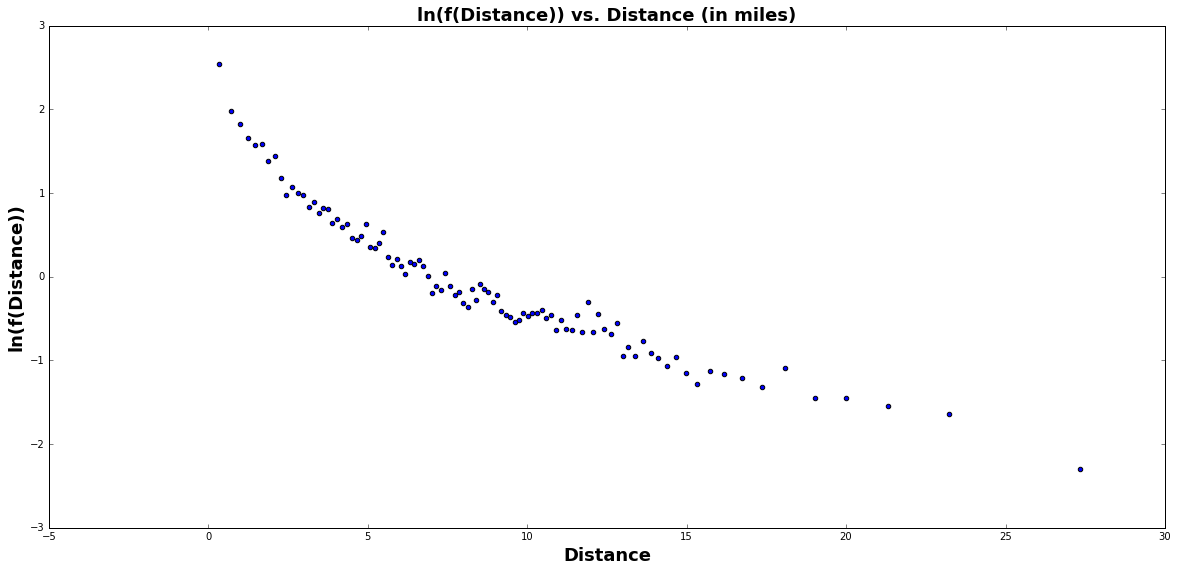

In [38]:
plt.scatter(GM.DistMean2_adj, GM.F_Dist2_adj.f_Dist)
plt.title('ln(f(Distance)) vs. Distance (in miles)', fontweight = 'bold', size = 18)
plt.ylabel('ln(f(Distance))', fontweight = 'bold', size = 18)
plt.xlabel('Distance', fontweight = 'bold', size = 18)

## It appears that the $ln(f(distance))$ does look like a logarithm function (with negative sign of course), and we now fit it with multiple models
### For better approximation effect, we will leave out the last ten or fifteen points as outliers if needed, as we believe that once the distance has passed a certain "threshold", the impact of it will become irrelavant, and we will use "15 miles" as this threshold judging by the plot (which, currently, covers more than 88% of the all distance data in NYC)

# Model 1 $$f(dist) = \frac {1}{a \cdot dist + b}$$

In [39]:
dist_range = np.arange(0.5,25, 0.1)

The coefficients of this model are a = 0.184839, b = -0.217617
The R square of this model is 0.922512


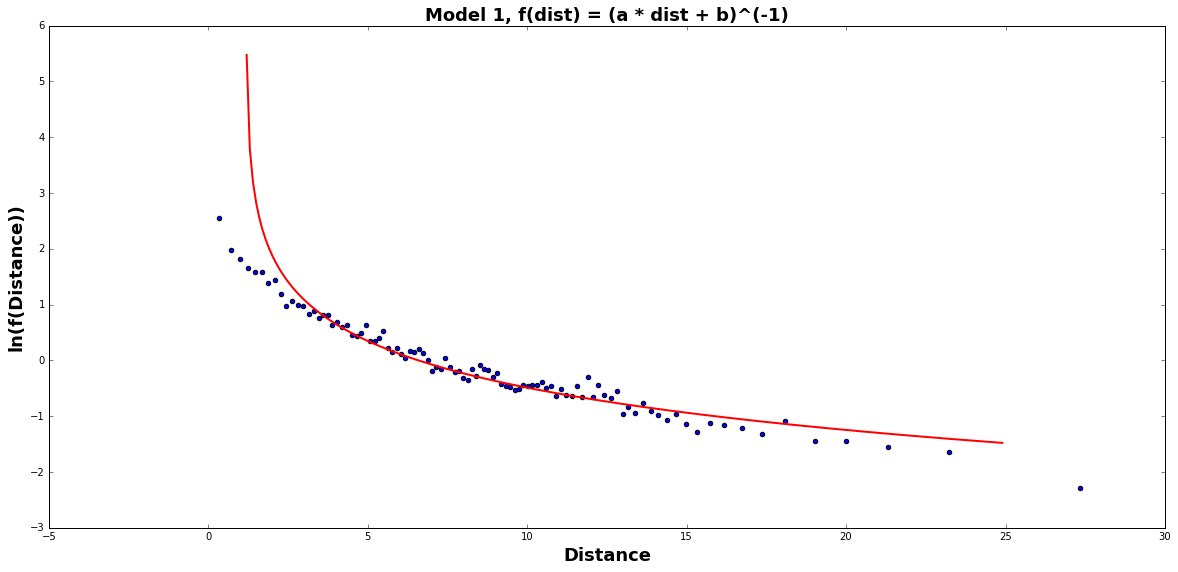

In [44]:
plt.scatter(GM.DistMean2_adj, GM.F_Dist2_adj.f_Dist)
model1 = ols(y = 1.0/exp(GM.F_Dist2_adj.f_Dist)[:-10], x = pd.DataFrame(GM.DistMean2_adj)[:-10])
(a1,b1) = model1.summary_as_matrix.loc['beta']
plt.plot(dist_range, [-log(a1*i+b1) for i in dist_range], '-r', lw = 2)
plt.title('Model 1, f(dist) = (a * dist + b)^(-1)', fontweight = 'bold', size = 18)
plt.ylabel('ln(f(Distance))', fontweight = 'bold', size = 18)
plt.xlabel('Distance', fontweight = 'bold', size = 18)
print('The coefficients of this model are a = %f, b = %f'%(a1,b1))
print('The R square of this model is %f'%model1.r2)

In [45]:
model1


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <0> + <intercept>

Number of Observations:         90
Number of Degrees of Freedom:   2

R-squared:         0.9225
Adj R-squared:     0.9216

Rmse:              0.2116

F-stat (1, 88):  1047.6580, p-value:     0.0000

Degrees of Freedom: model 1, resid 88

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
             0     0.1848     0.0057      32.37     0.0000     0.1736     0.1960
     intercept    -0.2176     0.0492      -4.43     0.0000    -0.3140    -0.1213
---------------------------------End of Summary---------------------------------

# Model 2 $$f(dist) = e^b \cdot dist^a$$
## In other words, $ln(f(dist)) = a \cdot ln(dist) + b$

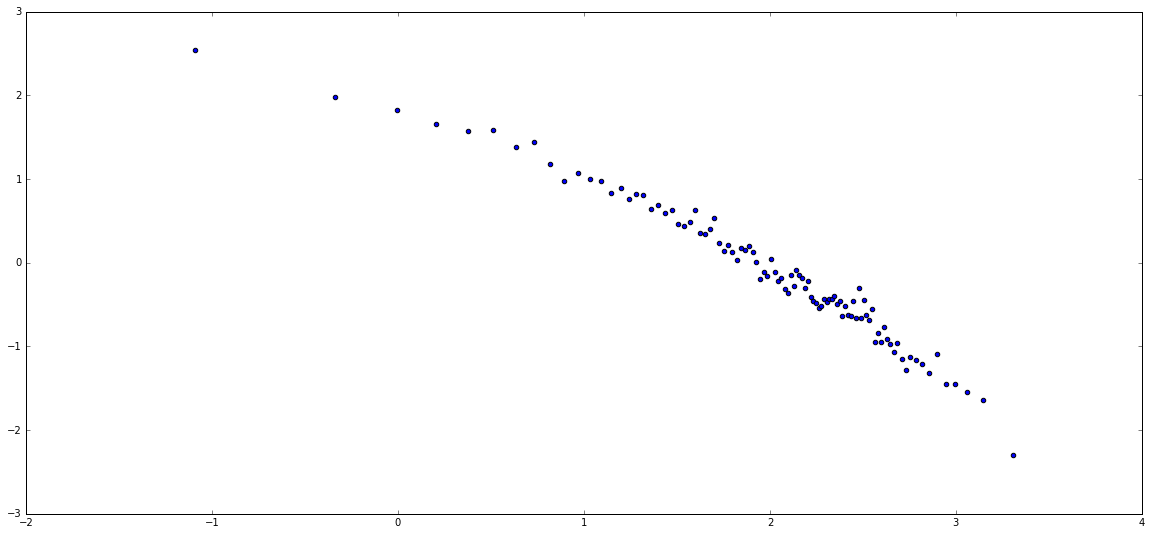

In [46]:
plt.scatter(log(GM.DistMean2_adj), GM.F_Dist2_adj.f_Dist)

The coefficients of this model are a = -1.107471, b = 2.078107
The R square of this model is 0.957354


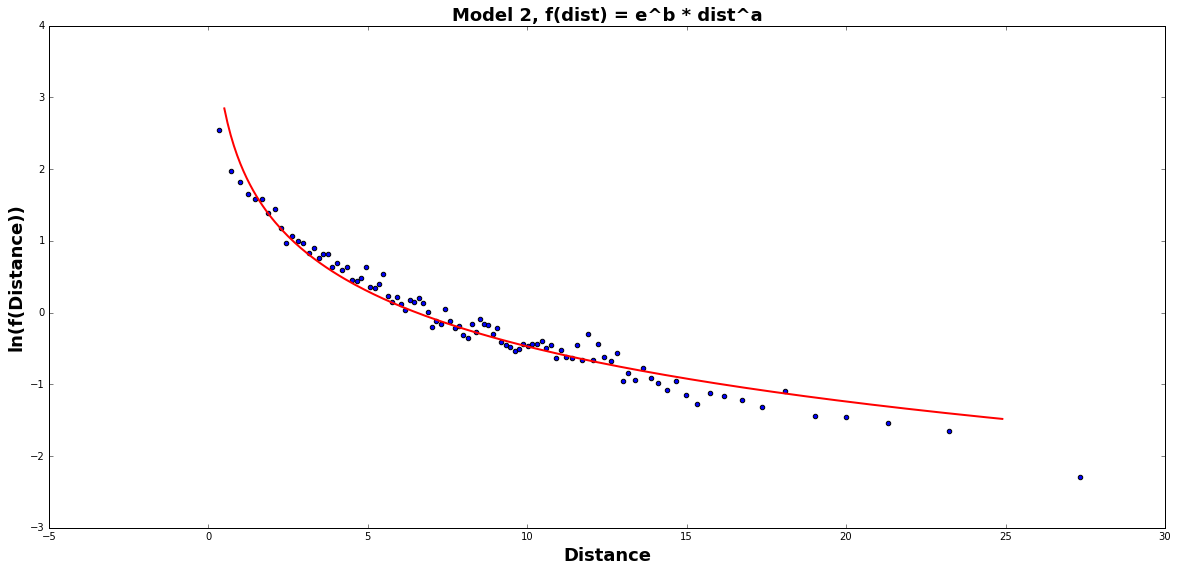

In [47]:
model2 = ols(y = GM.F_Dist2_adj.f_Dist, x = pd.DataFrame(log(GM.DistMean2_adj)))
(a2,b2) = model2.beta

plt.scatter(GM.DistMean2_adj, GM.F_Dist2_adj.f_Dist)
plt.title('Model 2, f(dist) = e^b * dist^a', fontweight = 'bold', size = 18)
plt.ylabel('ln(f(Distance))', fontweight = 'bold', size = 18)
plt.xlabel('Distance', fontweight = 'bold', size = 18)
plt.plot(dist_range,[a2*log(i)+b2 for i in dist_range],'-r',lw=2)
print('The coefficients of this model are a = %f, b = %f'%(a2,b2))
print('The R square of this model is %f'%model2.r2)

In [48]:
model2


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <0> + <intercept>

Number of Observations:         100
Number of Degrees of Freedom:   2

R-squared:         0.9574
Adj R-squared:     0.9569

Rmse:              0.1817

F-stat (1, 98):  2199.9639, p-value:     0.0000

Degrees of Freedom: model 1, resid 98

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
             0    -1.1075     0.0236     -46.90     0.0000    -1.1537    -1.0612
     intercept     2.0781     0.0496      41.92     0.0000     1.9810     2.1753
---------------------------------End of Summary---------------------------------

# Model 3
## More generally, $$f(dist) = a \cdot dist^q + b$$  We start by trying $q$ =-1, and then we search for $q^*$ in an interval such that the $R^2$ of our model achieves its maximum at $q^*$

The coefficients of this model are a = 4.871262, b = 0.359464
The R square of this model is 0.927525


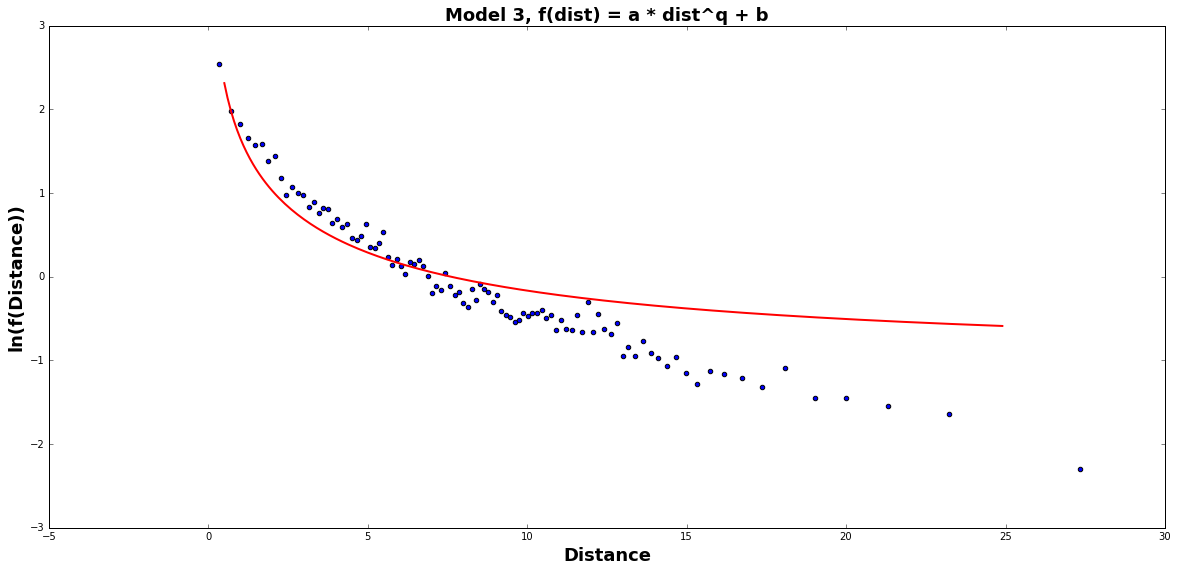

In [52]:
q = -1

x3 = [i**q for i in GM.DistMean2_adj]
plt.scatter(GM.DistMean2, GM.F_Dist2_adj.f_Dist)
model3 = ols(y = exp(GM.F_Dist2_adj.f_Dist), x = pd.DataFrame(x3))
(a3,b3) = model3.beta
plt.plot(dist_range, [log(a3*(i**q)+b3) for i in dist_range], '-r',lw=2)
plt.ylabel('ln(f(Distance))', fontweight = 'bold', size = 18)
plt.xlabel('Distance', fontweight = 'bold', size = 18)
plt.title('Model 3, f(dist) = a * dist^q + b', fontweight = 'bold', size = 18)
print('The coefficients of this model are a = %f, b = %f'%(a3,b3))
print('The R square of this model is %f'%model3.r2)

The optimal q is -0.620000
The coefficients of this model are a = 6.627180, b = -0.948016
The R square of this model is 0.990390


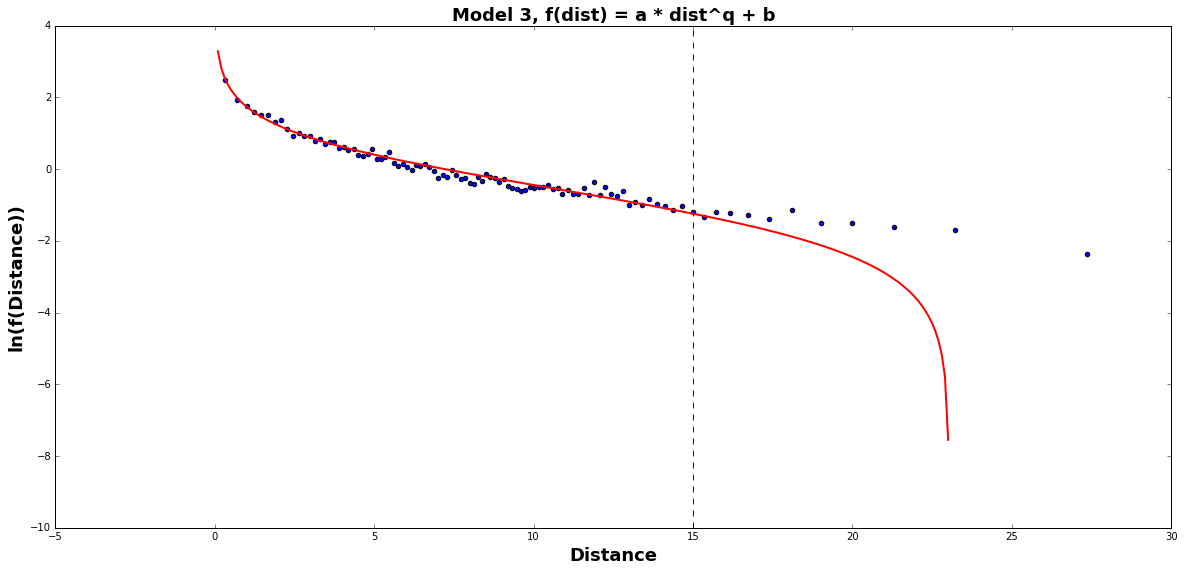

In [11]:
GM.Search_qstar_model3()

## So if we ignore the links "longer than 15 miles"--since the connection on that scale could be very weak in reality--this new model fits the data really well. And statistically speaking, more than 88% of the distance data falls below this threshold.
## (In fact, the distance between Wall Street and Yankee Stadium is less than 13 miles, and  about 18 miles from Central Park to Coney Island)
## Hence, one possible model is $$f(dist) = 6.627180 \cdot dist^{-0.62} - 0.948016$$

# Model 4
## Generalization of model 1:  $$f(dist) = \frac {1}{(a \cdot dist + b)^q}$$

The optimal q is 2.170000
The coefficients of this model are a = 0.083281, b = 0.417067
The R square of this model is 0.972983


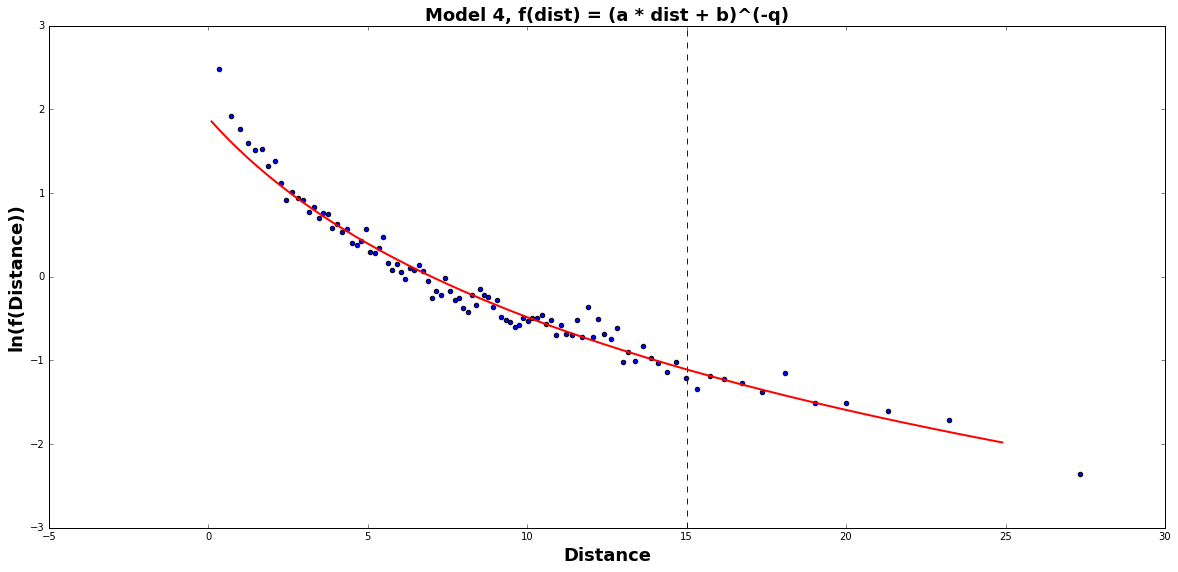

In [12]:
GM.Search_qstar_model4()

## The biggest advantage of model4, compared to model3, is we don't need to drop any so-called "outliers" anymore, this model basically fits for all data. But the $R^2$ drops slightly, and judging from the plot, its prediction accuracy may be weaker than model3 for smaller values (dist < 2 miles).
## The model looks like:  $$f(dist) = \frac {1}{(0.083281 \cdot dist + 0.417067)^{2.17}}$$

#  All parameters are estimated based on Twitter data from Nov. 2015 to Feb. 2016, we'll test these models when new data is available (from March to April)